In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)


--- RANDOM FOREST PİPELİNE BAŞLATILDI ---
En iyi parametreler aranıyor (Bu işlem ağaç sayısı nedeniyle biraz sürebilir)...
En İyi Parametreler: {'max_depth': None, 'max_features': 5, 'min_samples_split': 5, 'n_estimators': 200}

[Random Forest Classification Report]:
              precision    recall  f1-score   support

           0       0.90      0.76      0.82        82
           1       0.83      0.93      0.88       102

    accuracy                           0.85       184
   macro avg       0.86      0.84      0.85       184
weighted avg       0.86      0.85      0.85       184

CV Accuracy: 0.8692
CV F1-score: 0.8846
CV ROC AUC: 0.9354


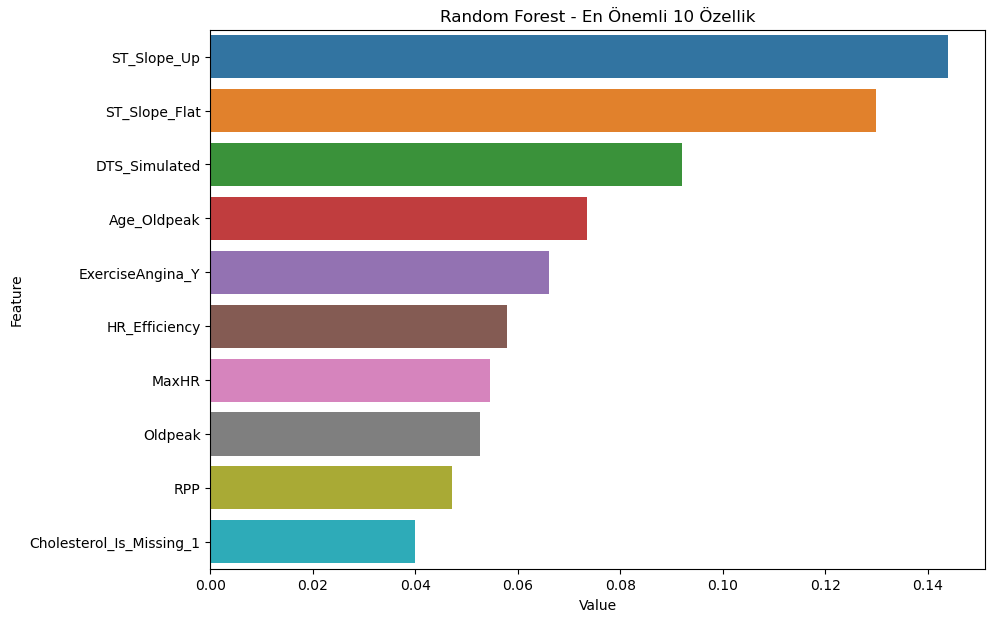

In [3]:
# ==========================================================
# MODÜL 1: DEĞİŞKEN AYRIŞTIRMA (grab_col_names)
# ==========================================================
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    return cat_cols, num_cols, cat_but_car

# ==========================================================
# MODÜL 2: ÖZELLİK MÜHENDİSLİĞİ (create_new_features)
# ==========================================================
def create_new_features(df):
    df_new = df.copy()
    
    # 1. Klinik Skorlar ve Etkileşimler
    df_new['RPP'] = (df_new['RestingBP'] * df_new['MaxHR']) / 100
    
    # ExerciseAngina'yı sayısal işleme hazırlama
    angina_map = {'Y': 1, 'N': 0}
    
    # DTS: Duke Treadmill Score Simülasyonu
    df_new['DTS_Simulated'] = 1 - (5 * df_new['Oldpeak']) - (4 * df_new['ExerciseAngina'].map(angina_map))
    
    df_new['HR_Efficiency'] = df_new['MaxHR'] / (220 - df_new['Age'])
    df_new['Age_Oldpeak'] = df_new['Age'] * df_new['Oldpeak']

    # 2. Risk Grupları ve Kategorizasyon
    df_new['HighChol'] = (df_new['Cholesterol'] > 200).astype(int)
    
    # AgeGroup_Optimized: Yaşa dayalı risk segmentasyonu
    df_new['AgeGroup_Optimized'] = pd.cut(
        df_new['Age'], 
        bins=[0, 45, 55, 120], 
        labels=['Young', 'Middle', 'Senior+']
    )
    
    df_new['MetabolicRisk'] = ((df_new['FastingBS'] == 1) & (df_new['HighChol'] == 1)).astype(int)
    
    return df_new

# ==========================================================
# MODÜL 3: VERİ ÖN İŞLEME (Preprocessing & Leakage Protection)
# ==========================================================
def heart_data_prep(X_train, X_test):
    # Train ve Test kopyaları üzerinden işlem yapma
    X_train_prep = X_train.copy()
    X_test_prep = X_test.copy()

    # 1. Hatalı/Eksik Veri İşaretleme
    for df in [X_train_prep, X_test_prep]:
        # Kolesterol 0 değerlerini NaN yap
        df['Cholesterol_Is_Missing'] = (df['Cholesterol'] == 0).astype(int)
        df['Cholesterol'] = df['Cholesterol'].replace(0, np.nan)
        # Kan Basıncı 0 değerlerini NaN yap
        df['RestingBP'] = df['RestingBP'].replace(0, np.nan)

    # 2. Sızıntısız Doldurma (Imputation)
    # Sadece TRAIN setinden istatistikleri alıyoruz
    chol_medians = X_train_prep.groupby('Sex')['Cholesterol'].median()
    bp_median = X_train_prep['RestingBP'].median()

    # Train ve Test setlerini Train'den gelen bilgiyle doldurma
    for gender in ['M', 'F']:
        X_train_prep.loc[(X_train_prep['Sex'] == gender) & (X_train_prep['Cholesterol'].isna()), 'Cholesterol'] = chol_medians[gender]
        X_test_prep.loc[(X_test_prep['Sex'] == gender) & (X_test_prep['Cholesterol'].isna()), 'Cholesterol'] = chol_medians[gender]

    X_train_prep['RestingBP'] = X_train_prep['RestingBP'].fillna(bp_median)
    X_test_prep['RestingBP'] = X_test_prep['RestingBP'].fillna(bp_median)

    # 3. Encoding İşlemi
    # Önce kolonları belirle
    cat_cols, num_cols, cat_but_car = grab_col_names(X_train_prep)
    
    # One-Hot Encoding (Dummies)
    X_train_prep = pd.get_dummies(X_train_prep, columns=cat_cols, drop_first=True)
    X_test_prep = pd.get_dummies(X_test_prep, columns=cat_cols, drop_first=True)

    # Kolon eşitleme (Train'de olup Test'te olmayan kolonları 0 ile doldur)
    X_test_prep = X_test_prep.reindex(columns=X_train_prep.columns, fill_value=0)

    return X_train_prep, X_test_prep

# ==========================================================
# MODÜL 4: FINAL PIPELINE
# ==========================================================
def run_rf_pipeline(df, target="HeartDisease"):
    print("\n--- RANDOM FOREST PİPELİNE BAŞLATILDI ---")
    
    # 1. Özellik Mühendisliği (Modül 2)
    df_enriched = create_new_features(df)
    
    # 2. Train-Test Ayırma
    y = df_enriched[target]
    X = df_enriched.drop(target, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=17)
    
    # 3. Ön İşleme (Modül 3)
    X_train_prep, X_test_prep = heart_data_prep(X_train, X_test)
    
    # 4. Hiperparametre Optimizasyonu (Grid Search)
    rf_model = RandomForestClassifier(random_state=17)
    
    # CART'tan farklı olarak n_estimators (ağaç sayısı) ve max_features eklendi
    rf_params = {"max_depth": [5, 8, None],
                 "max_features": [3, 5, 7, "sqrt"],
                 "min_samples_split": [2, 5, 10],
                 "n_estimators": [100, 200, 500]}
    
    
    print("En iyi parametreler aranıyor (Bu işlem ağaç sayısı nedeniyle biraz sürebilir)...")
    rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=0).fit(X_train_prep, y_train)
    print(f"En İyi Parametreler: {rf_best_grid.best_params_}")
    
    # 5. Final Model ve Değerlendirme
    rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_train_prep, y_train)
    y_pred = rf_final.predict(X_test_prep)
    
    print("\n[Random Forest Classification Report]:")
    print(classification_report(y_test, y_pred))
    
    # 6. Çapraz Doğrulama (Cross Validation)
    cv_results = cross_validate(rf_final, X_train_prep, y_train, cv=10, 
                                 scoring=["accuracy", "f1", "roc_auc"])
    
    print(f"CV Accuracy: {cv_results['test_accuracy'].mean():.4f}")
    print(f"CV F1-score: {cv_results['test_f1'].mean():.4f}")
    print(f"CV ROC AUC: {cv_results['test_roc_auc'].mean():.4f}")
    
    # 7. Özellik Önem Sıralaması (Feature Importance)
    feature_imp = pd.DataFrame({'Value': rf_final.feature_importances_, 'Feature': X_train_prep.columns})
    plt.figure(figsize=(10, 7))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(10))
    plt.title('Random Forest - En Önemli 10 Özellik')
    plt.show()
    
    return rf_final

# ÇALIŞTIRMA:
def load():
    data = pd.read_csv("dataset/heart.csv")
    return data
df = load()
rf_final_model = run_rf_pipeline(df)